In [1]:
import read_data as imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf
import pyfolio

import warnings
warnings.filterwarnings("ignore")

C:\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def find_median(x):
    aux = [0 for k in range(x.shape[0])]
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            aux[i] += np.linalg.norm(x.iloc[i,]-x.iloc[j,])
    return x.iloc[aux == min(aux),].iloc[0,]

In [3]:
symbols = ['XLP','XLY','XLE','XLF','XLV','XLI','XLK','XLU']
years = [x for x in range(2000,2019)]
hist_data = imp.organizarTodo(symbols,years)

Daily_Assets = pd.DataFrame()
Daily_Log_Assets = pd.DataFrame()

for asset,df in hist_data.items():
    Daily_Assets[asset] = df['Close']
    Daily_Log_Assets[asset] = np.log(df['Close']/df['Close'].shift(1))

In [4]:
Assets = pd.read_csv('Data.csv')
Assets.set_index('Date', inplace=True)
Assets.index = pd.to_datetime(Assets.index)
Log_Assets = np.log(Assets/Assets.shift(1))
Log_Assets = Log_Assets.dropna()

In [5]:
np.random.seed(42)
num_ports = 1000

T_N = 6
the_start = np.where(Daily_Assets.index == Log_Assets.index[T_N])[0][0]

In [6]:
Mark_Ret = np.zeros(Daily_Assets.shape[0]-the_start)
RMark_Ret = np.zeros(Daily_Assets.shape[0]-the_start)
R2Mark_Ret = np.zeros(Daily_Assets.shape[0]-the_start)

Curr_Wi = np.zeros(len(Assets.columns))
RCurr_Wi = np.zeros(len(Assets.columns))
R2Curr_Wi = np.zeros(len(Assets.columns))

WC = pd.DataFrame(index=Log_Assets.index, columns= Log_Assets.columns)
WR = pd.DataFrame(index=Log_Assets.index, columns= Log_Assets.columns)
WR2 = pd.DataFrame(index=Log_Assets.index, columns= Log_Assets.columns)

indaux = T_N

for i in range(the_start, Daily_Assets.shape[0]):
        
    if Daily_Assets.index[i] in Assets.index:
        all_weights = np.zeros((num_ports, len(Assets.columns)))
        Rall_weights = np.zeros((num_ports, len(Assets.columns)))
        R2all_weights = np.zeros((num_ports, len(Assets.columns)))
        
        sharpe_arr = np.zeros(num_ports)
        Rsharpe_arr = np.zeros(num_ports)
        R2sharpe_arr = np.zeros(num_ports)

        for x in range(num_ports):
            # Weights
            weights = np.array(np.random.uniform(-1,1,len(Assets.columns)))
            weights = weights/np.sum(weights)

            # Save weights
            all_weights[x,:] = weights
            Rall_weights[x,:] = weights
            R2all_weights[x,:] = weights

            # Expected return
            ret_arr = np.sum((Log_Assets.iloc[indaux-T_N:indaux,:].mean() * weights * 252))
            Rret_arr = np.sum((Log_Assets.iloc[indaux-T_N:indaux,:].median() * weights * 252))
            R2ret_arr = np.sum((find_median(Log_Assets.iloc[indaux-T_N:indaux,:]) * weights * 252))

            # Expected volatility
            vol_arr = np.sqrt(np.dot(weights.T, np.dot(Log_Assets.iloc[indaux-T_N:indaux,:].cov()*252, weights)))
            
            LW_Cov = LedoitWolf().fit(Log_Assets.iloc[indaux-T_N:indaux,:]).covariance_
            Rvol_arr = np.sqrt(np.dot(weights.T, np.dot(LW_Cov*252, weights)))

            # Sharpe Ratio
            sharpe_arr[x] = ret_arr/vol_arr
            Rsharpe_arr[x] = Rret_arr/Rvol_arr
            R2sharpe_arr[x] = R2ret_arr/Rvol_arr
                       
            
        Curr_Wi = np.round(all_weights[sharpe_arr.argmax(),:], decimals = 3)
        RCurr_Wi = np.round(Rall_weights[Rsharpe_arr.argmax(),:], decimals = 3)
        R2Curr_Wi = np.round(Rall_weights[R2sharpe_arr.argmax(),:], decimals = 3)
        
        WC.iloc[indaux,] = Curr_Wi
        WR.iloc[indaux,] = RCurr_Wi
        WR2.iloc[indaux,] = R2Curr_Wi
        
        Mark_Ret[i-the_start] = np.dot(Daily_Log_Assets.iloc[i,],Curr_Wi)
        RMark_Ret[i-the_start] = np.dot(Daily_Log_Assets.iloc[i,],RCurr_Wi)
        R2Mark_Ret[i-the_start] = np.dot(Daily_Log_Assets.iloc[i,],R2Curr_Wi)
        
        indaux += 1
    else:
        Mark_Ret[i-the_start] = np.dot(Daily_Log_Assets.iloc[i,],Curr_Wi)
        RMark_Ret[i-the_start] = np.dot(Daily_Log_Assets.iloc[i,],RCurr_Wi)
        R2Mark_Ret[i-the_start] = np.dot(Daily_Log_Assets.iloc[i,],R2Curr_Wi)

## Weights Behivor

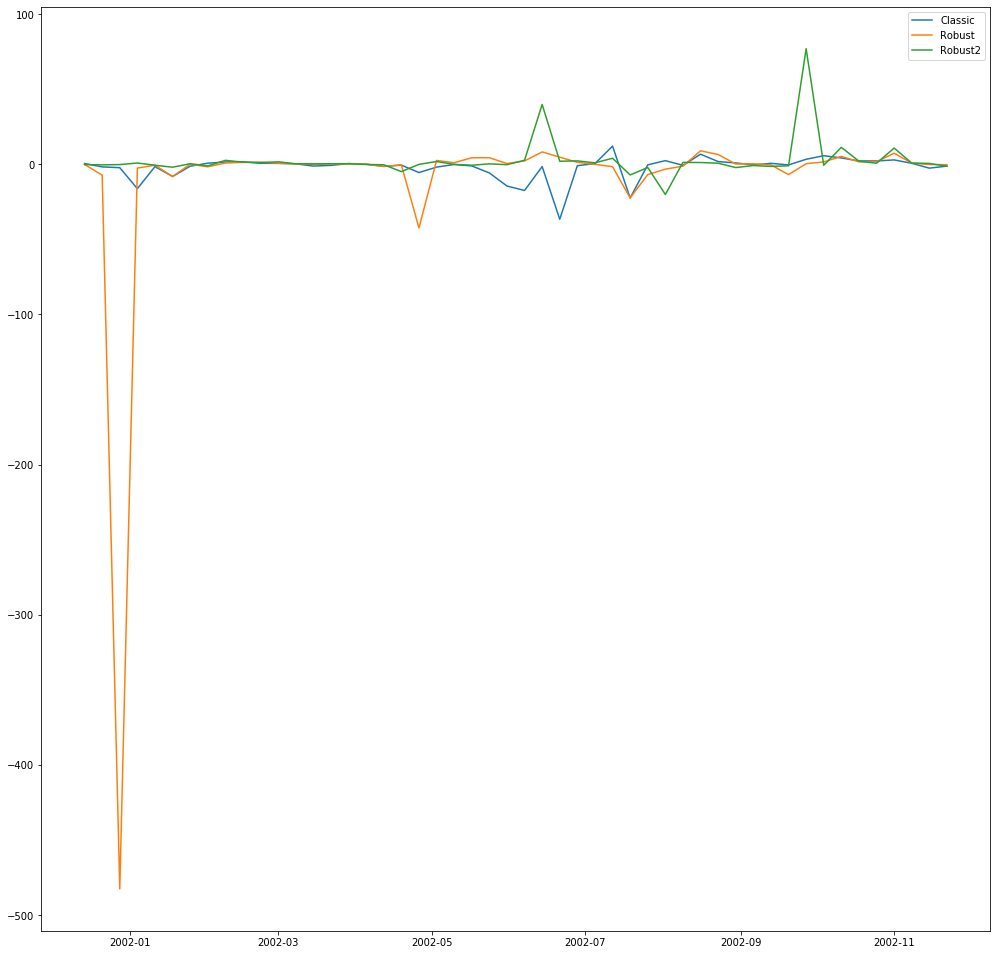

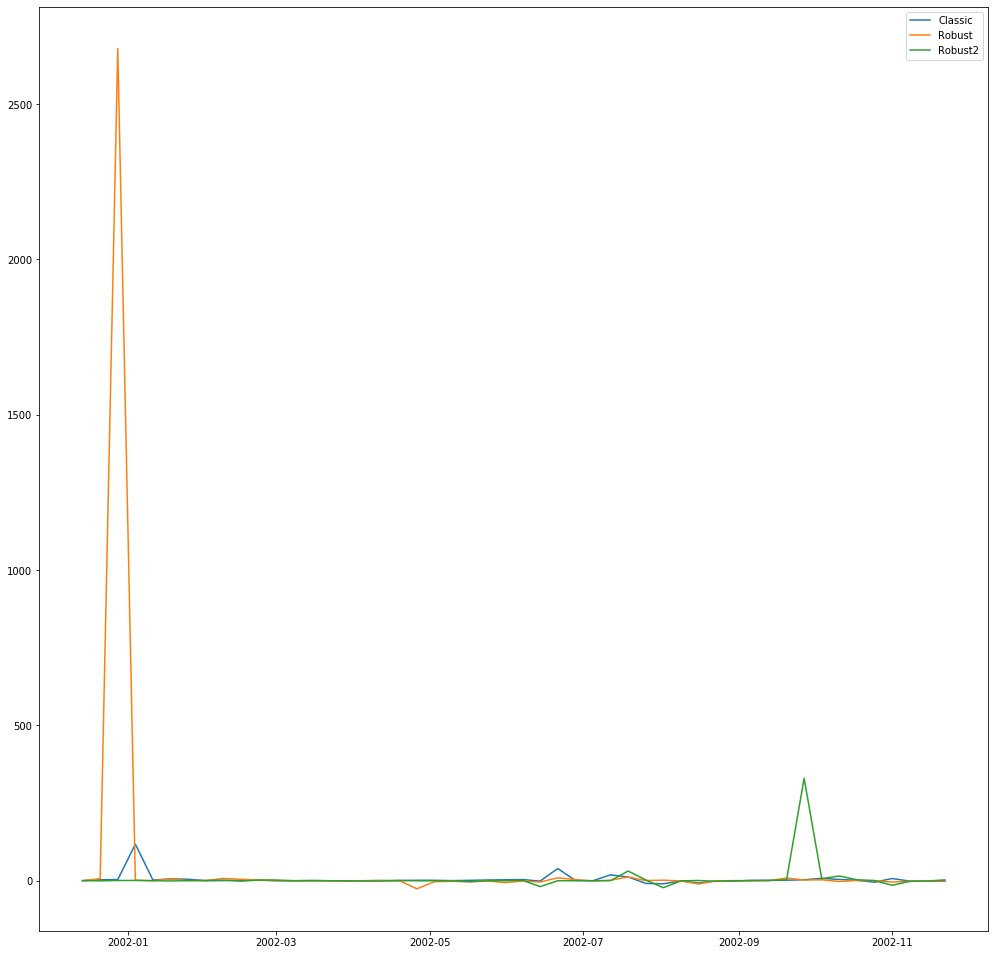

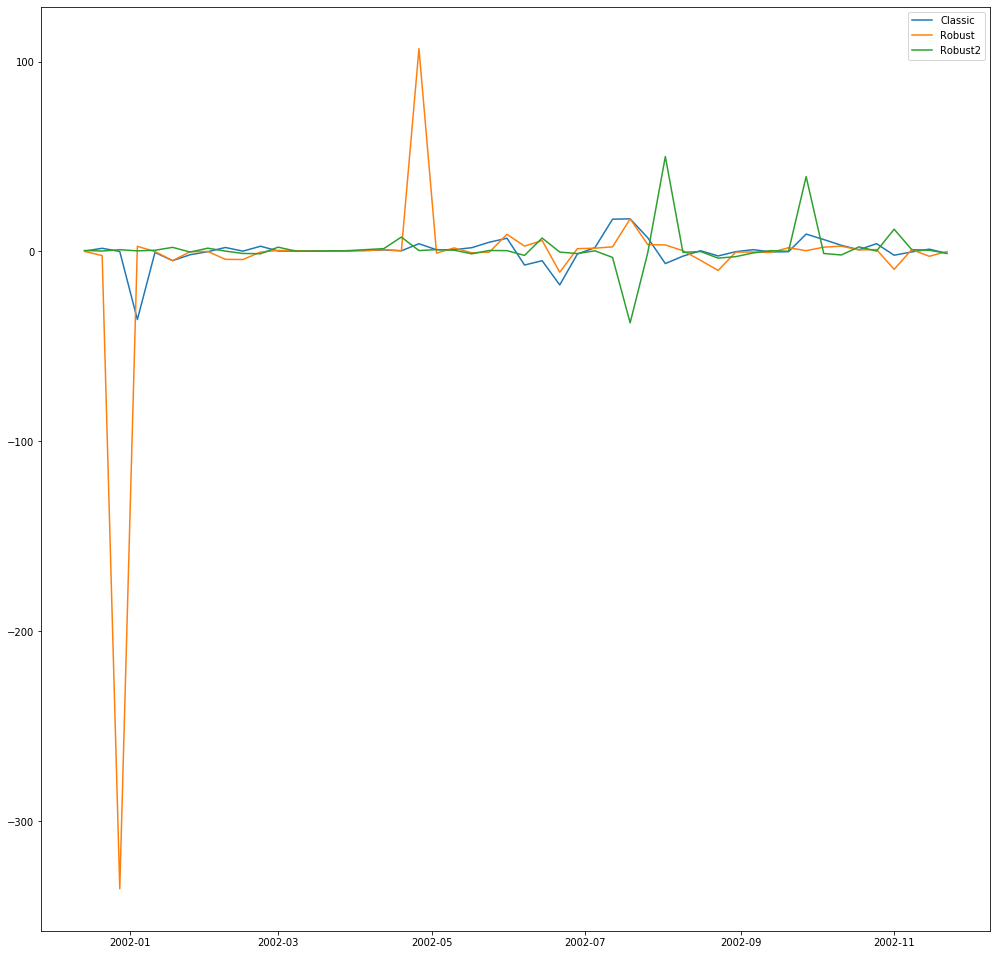

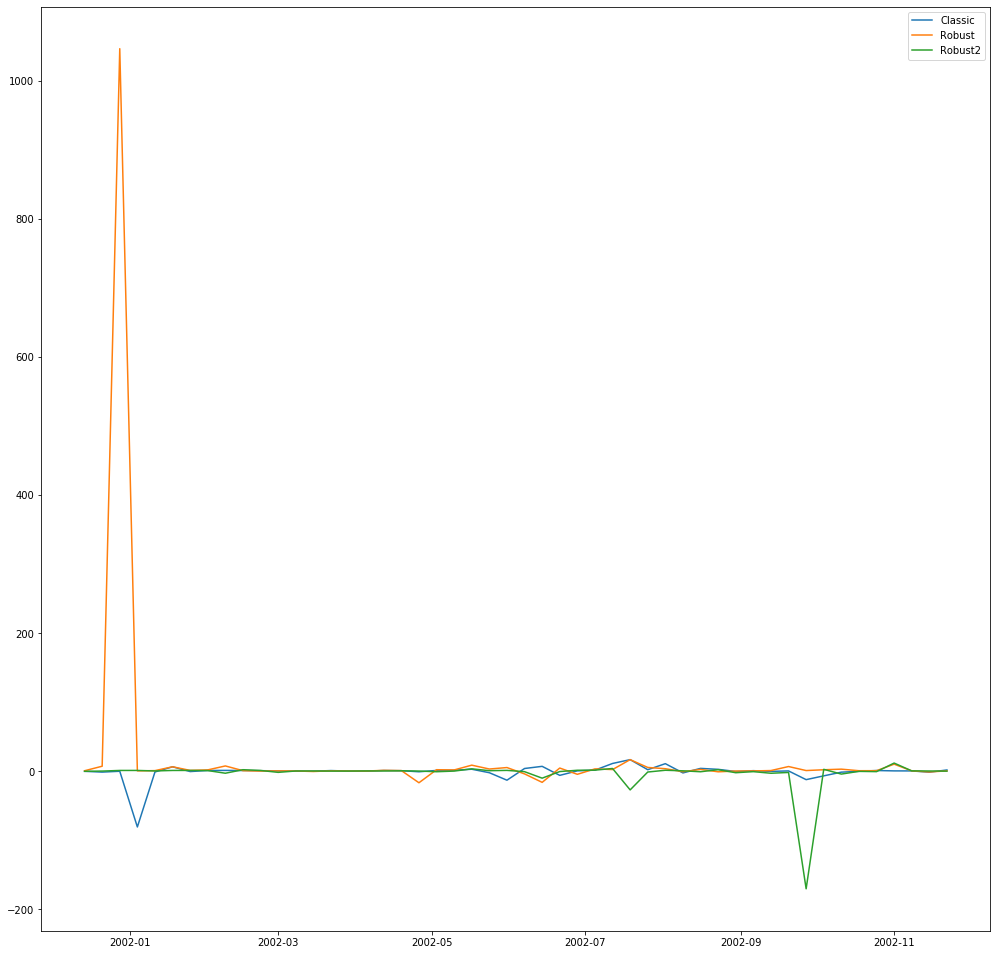

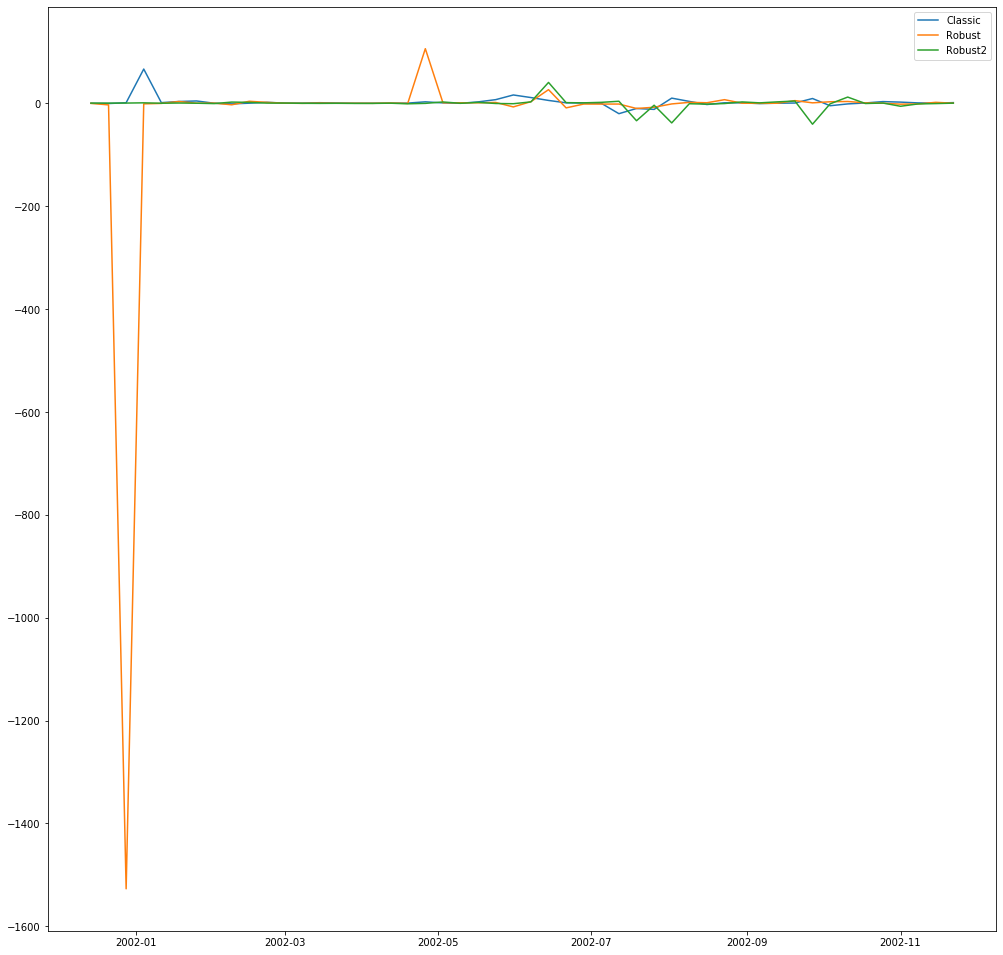

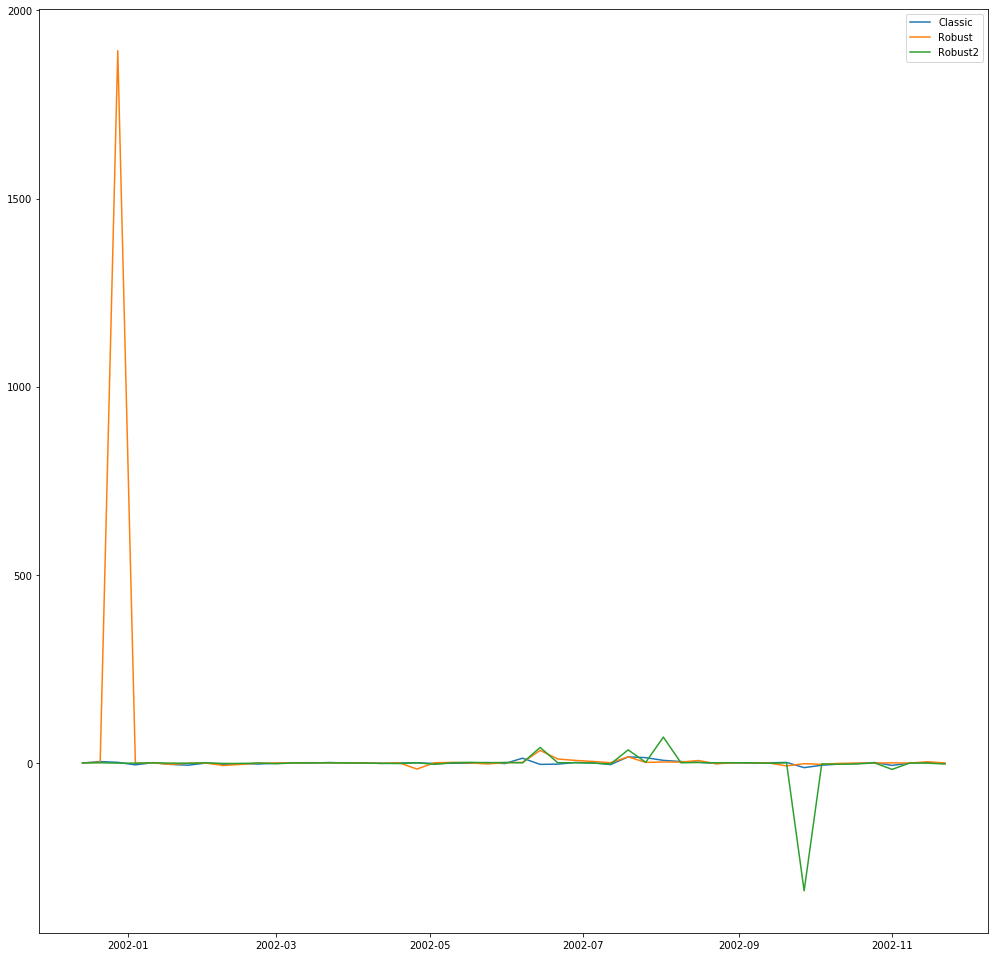

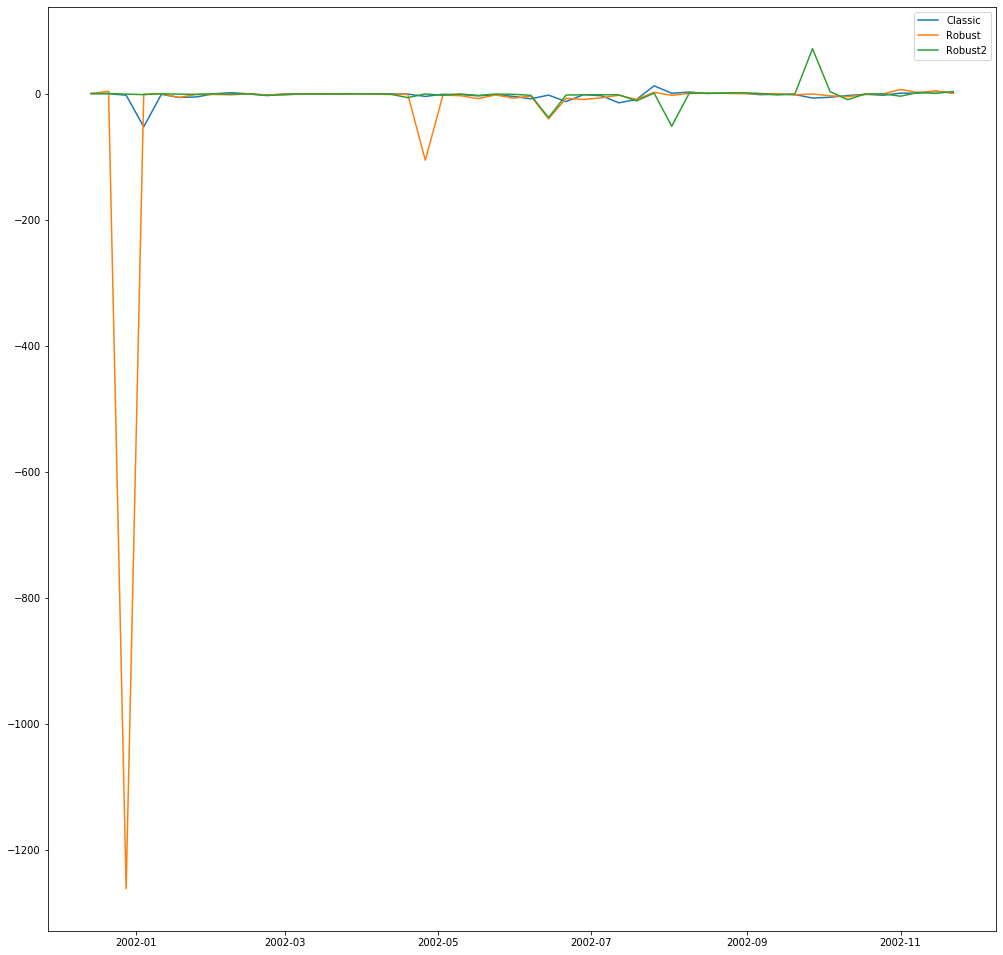

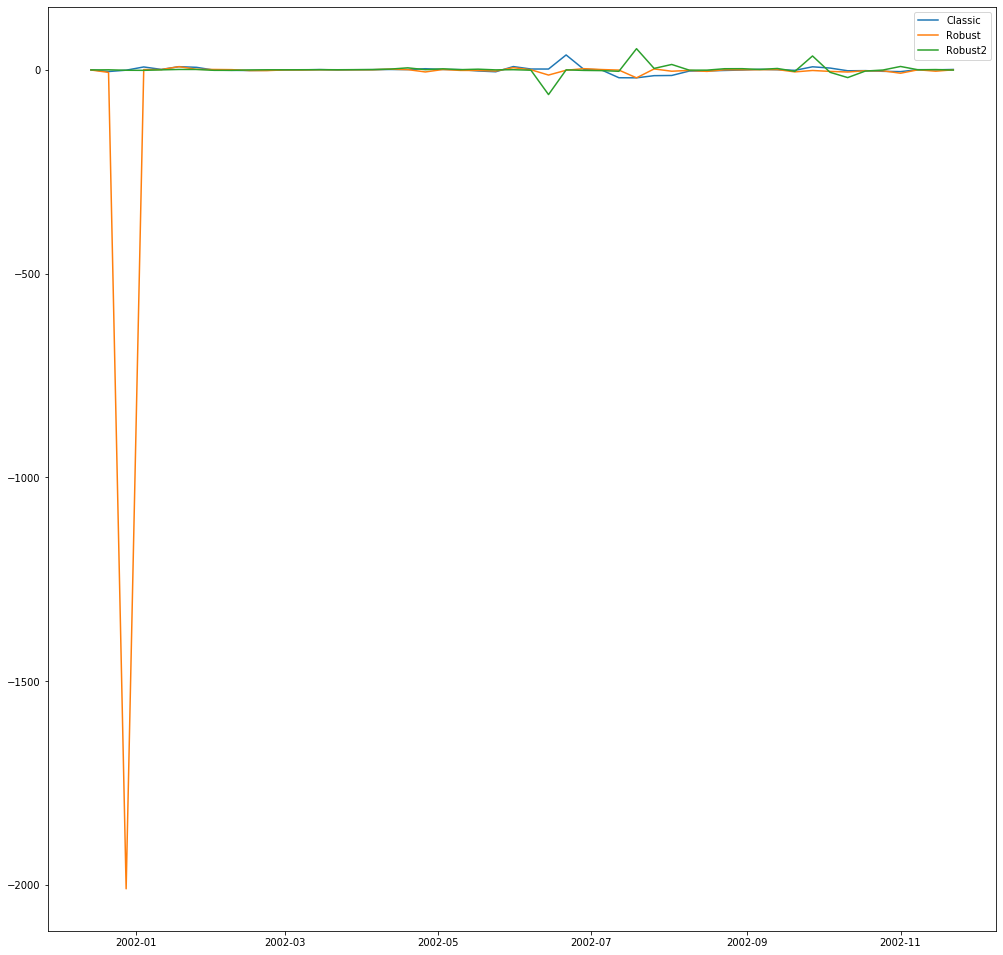

In [7]:
for asset in symbols:
    plt.figure(figsize=(17,17))
    plt.plot(WC[asset][100:150])
    plt.plot(WR[asset][100:150])
    plt.plot(WR2[asset][100:150])
    plt.legend(['Classic', 'Robust', 'Robust2'])
    plt.show()

## Comparison

In [8]:
Markowitz_Comparison = pd.DataFrame()
Markowitz_Comparison['Classic'] = Mark_Ret
Markowitz_Comparison['Robust'] = RMark_Ret
Markowitz_Comparison['Robust2'] = R2Mark_Ret
Markowitz_Comparison.index = Daily_Assets.index[the_start:]
Markowitz_Comparison = Markowitz_Comparison.astype(float)

In [9]:
Markowitz_Comparison.to_excel('Resultados 10k portafolios.xlsx')

Start date,2000-02-25
End date,2019-01-01
Total months,234
,Backtest
Annual return,nan%
Cumulative returns,-2133097712.6%
Annual volatility,5802.9%
Sharpe ratio,0.29
Calmar ratio,NaN
Stability,NaN
Max drawdown,-55262.4%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,55262.36,2000-03-08,2002-10-16,2003-01-07,740
1,7650.27,2000-03-02,2000-03-07,2000-03-08,5
2,5090.25,2003-03-12,2003-04-21,2004-08-23,379
3,2301.84,2003-03-10,2003-03-11,2003-03-12,3
4,1010.74,2004-10-06,2009-03-06,2009-03-10,1155


Stress Events,mean,min,max
Dotcom,-8.89%,-549.97%,355.12%
Lehman,-2.59%,-98.32%,46.60%
9/11,-6.33%,-318.13%,121.43%
US downgrade/European Debt Crisis,-1.79%,-225.34%,254.48%
Fukushima,1.60%,-6.34%,9.62%
US Housing,1.35%,-56.47%,111.29%
EZB IR Event,-0.40%,-41.57%,41.05%
Aug07,0.45%,-10.95%,27.55%
Mar08,1.89%,-16.45%,38.26%
Sept08,-2.74%,-98.32%,46.60%


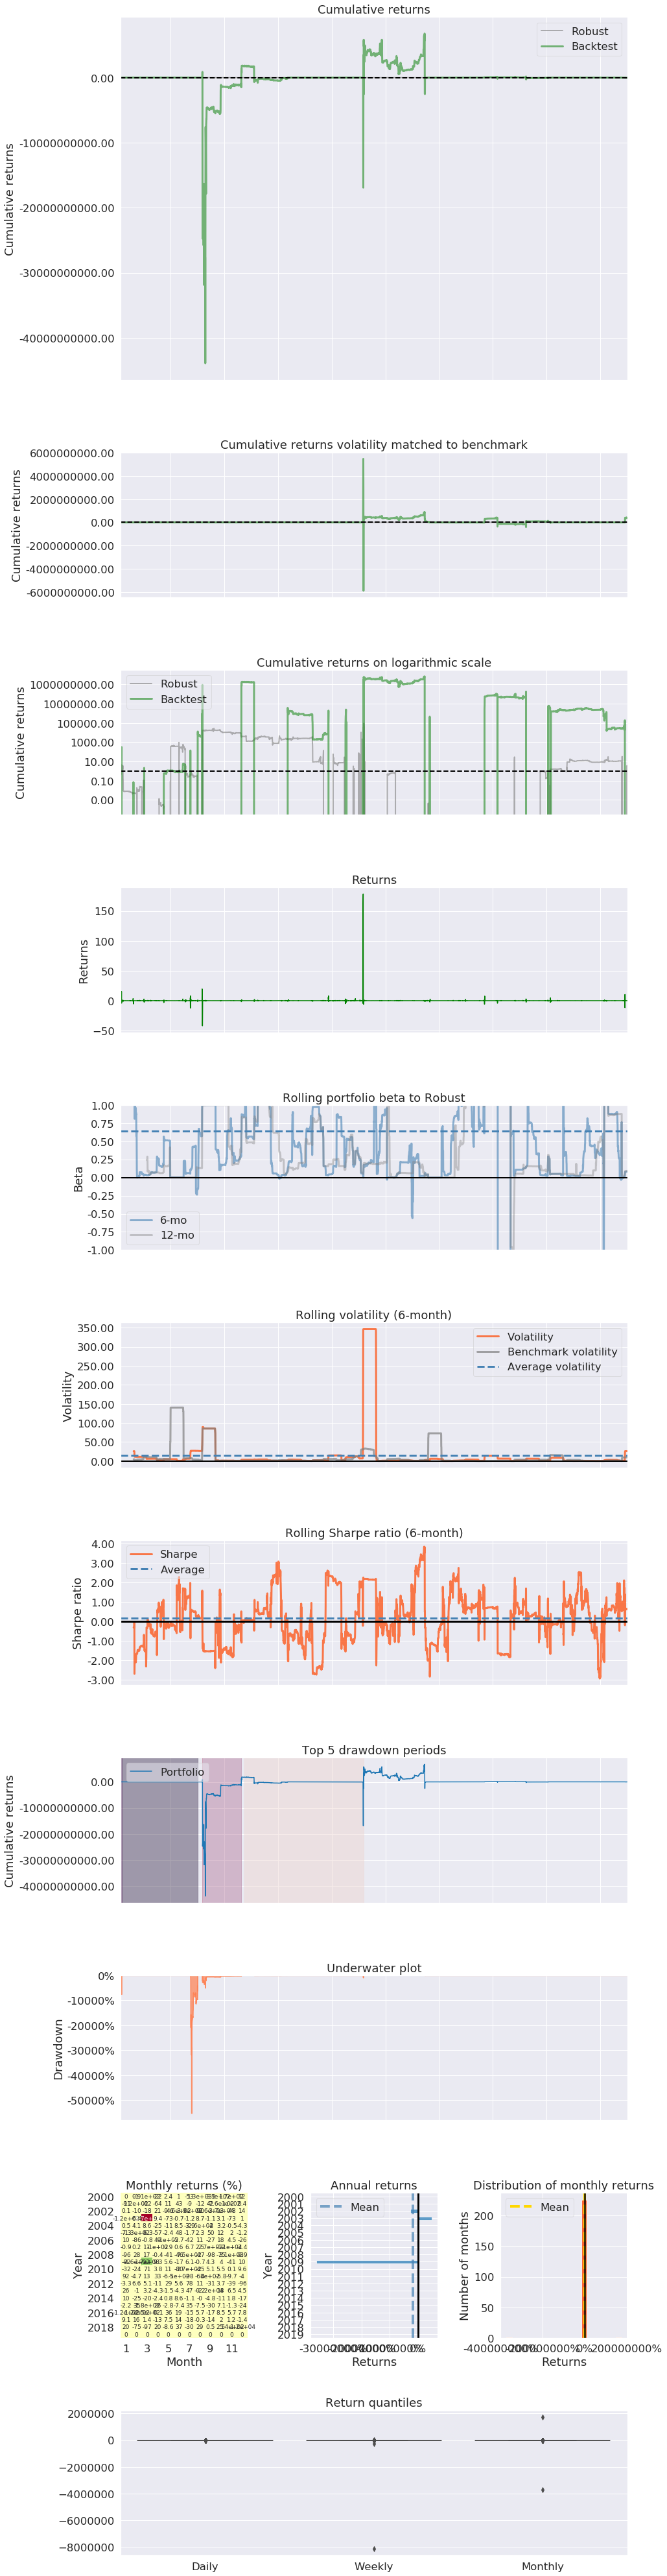

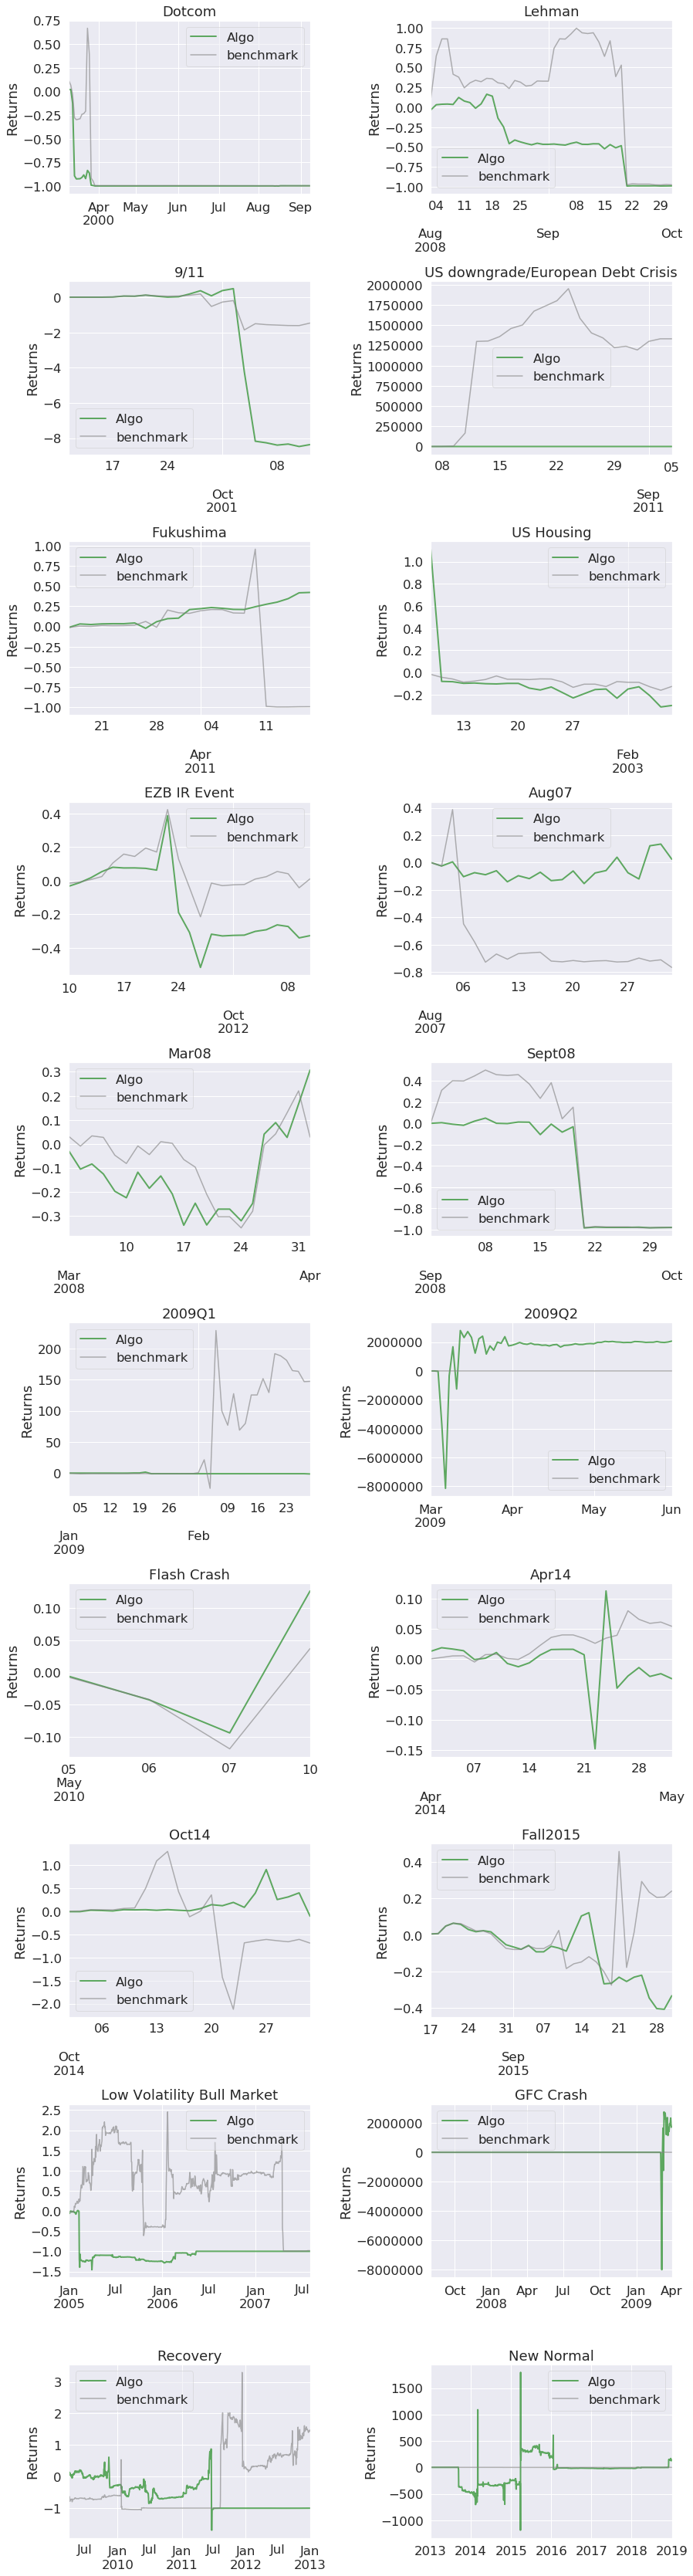

In [10]:
pyfolio.create_full_tear_sheet(Markowitz_Comparison['Robust2'], benchmark_rets=Markowitz_Comparison['Robust'])
plt.show()

In [ ]:
pyfolio.create_full_tear_sheet(Markowitz_Comparison['Classic'])#, benchmark_rets=Markowitz_Comparison['Classic'])
# plt.show()

In [ ]:
pyfolio.create_full_tear_sheet(Markowitz_Comparison['Robust'], benchmark_rets=Markowitz_Comparison['Classic'])